In [21]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.colors import TwoSlopeNorm
from tqdm import trange

In [22]:
# Parameters for the MDP and representation 
# It can only work here for Nsa = 2 and p = 1
# Feel free to change P and gamma
Nsa = 2
p = 1
gamma = 0.995
eta = 1e-3
Isa = np.eye(Nsa)
Ip = np.eye(p)

eps = 0.95
# P = np.array([[0,1], [eps, 1-eps]])
# P = np.ones((2,2))-eps
# P[0,0]=eps
# P[1,1]=eps
P = np.array([[1-eps, eps], [eps, 1-eps]])


# Iteration matrix for TD
A_TD = lambda phi, xi: Ip - eta*(phi.T@xi@(Isa-gamma*P)@phi)
# Iteration matrix for Projected Value Iteration
A_PVI = lambda phi, xi: gamma*np.linalg.pinv(phi.T@xi@phi)@phi.T@xi@P@phi
# Iteration matrix for target net (T)
A_TN = lambda phi, xi, T: np.linalg.matrix_power(Ip-eta*phi.T@xi@phi, T)@(Ip - A_PVI(phi, xi)) + A_PVI(phi, xi)
# Iteration matrix for FR (T)
A_FR = lambda phi, xi, k: k*np.linalg.pinv(phi.T@xi@((1+k)*Isa - gamma*P)@phi)@phi.T@xi@phi
A_FR_T = lambda phi, xi, k, T: np.linalg.matrix_power(Ip-eta*phi.T@xi@((1+k)*Isa - gamma*P)@phi, T)@(Ip-A_FR(phi, xi, k))+A_FR(phi, xi, k)

In [23]:
P

array([[0.05, 0.95],
       [0.95, 0.05]])

In [24]:
T=10000
kappa = 1.5
# Stationary policy of P
stat_pi = np.abs(np.linalg.eig(P.T)[1][:, 1])
stat_pi /= stat_pi.sum()
# stat_pi = np.sqrt(stat_pi)
print(stat_pi)

[0.5 0.5]


In [25]:
# Useful functions

# Spectral radius
def rho(M):
    return max(np.abs(np.linalg.eigvals(M)))

def plot_spectrum(A):
    spectrum = np.linalg.eigvals(A)
    for eig in spectrum:
        if np.real(eig)**2 + np.imag(eig)**2 < 1:
            plt.scatter(np.real(eig), np.imag(eig), color='black')
        else:
            plt.scatter(np.real(eig), np.imag(eig), color='red')
    plt.grid()
    plt.plot([np.cos(x) for x in np.linspace(0, 7, 1000)], [np.sin(x) for x in np.linspace(0, 7, 1000)])

In [26]:
N = 100 #N^2 will be the number of points in the mesh. We used N=1000 in the paper
vecN = np.linspace(0, 1, N)
radius_matrix, theta_matrix = np.meshgrid(vecN,2*np.pi*vecN)
radius_matrix = radius_matrix
grid_x = radius_matrix * np.cos(theta_matrix)
grid_y = radius_matrix * np.sin(theta_matrix)

z = radius_matrix

In [27]:
print(r'Stationary distribution', stat_pi)

Stationary distribution [0.5 0.5]


In [28]:
rho_algos = np.zeros((N, N, 5))
phis = np.zeros((2, 1))

max_clip = 10
for i in trange(N):
  for j in range(N):
    angle = vecN[j]*2*np.pi
    r = radius_matrix[0, i]
    phis[0, 0] = np.cos(angle)
    phis[1, 0] = (np.sin(angle))

    rho_algos[j,i, 0] = rho(A_TD(phis, np.diag([r, 1-r])))
    rho_algos[j,i, 1] = np.clip(rho(A_TN(phis, np.diag([r, 1-r]), T)), 0, max_clip)
    rho_algos[j,i, 2]= np.clip(rho(A_PVI(phis, np.diag([r, 1-r]))), 0, max_clip)
    rho_algos[j,i, 3] = np.clip(rho(A_FR(phis, np.diag([r, 1-r]), kappa)), 0, max_clip)
    rho_algos[j,i, 4] = np.clip(rho(A_FR_T(phis, np.diag([r, 1-r]), kappa, T)), 0, max_clip)

# Indices
#0 : TD
#1: TN (T)
#2 TN inf
#3: FR inf
#4 Fr (T)

##!!! Note that when plotting, we will use the spectral radius per update (to compare apples with apples), therefore it will be np.power(rho, 1/T) for TN and FR with period T

100%|██████████| 100/100 [00:11<00:00,  8.94it/s]


In [29]:
# Limits of the common colorbar
valmin = 0.999
valmax=1.0001

<ipython-input-31-e376c505bf86>:4: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  plt.pcolormesh(grid_x, grid_y, rho_algos[:,:,0], norm=TwoSlopeNorm(1, vmin=valmin, vmax=valmax), cmap='RdBu_r')
<ipython-input-31-e376c505bf86>:8: UserWarning: The following kwargs were not used by contour: 'style'
  plt.contour(grid_x, grid_y, np.sign(rho_algos[:,:,0]-1), 1, style='--')


(-1.099496542383185, 1.1, -1.099874127673875, 1.099874127673875)

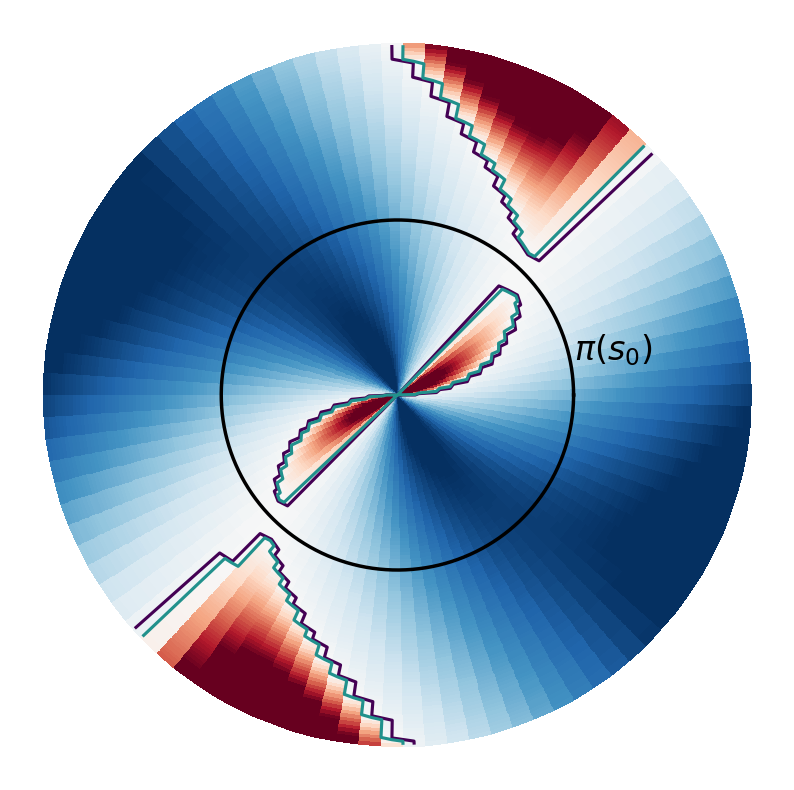

In [31]:
# TD
sns.set_context('talk')
plt.figure(figsize=(10,10))
plt.pcolormesh(grid_x, grid_y, rho_algos[:,:,0], norm=TwoSlopeNorm(1, vmin=valmin, vmax=valmax), cmap='RdBu_r')
plt.axis([grid_x.min()-0.1, grid_x.max()+0.1, grid_y.min()-0.1, grid_y.max()+0.1])
plt.plot(stat_pi[0]*np.cos(np.linspace(0, 2*np.pi, 500)), stat_pi[0]*np.sin(np.linspace(0, 2*np.pi, 500)), color='black', linewidth=2.5)
# plt.colorbar()
plt.contour(grid_x, grid_y, np.sign(rho_algos[:,:,0]-1), 1, style='--')
plt.text(0.50, 0.1, r'$\pi(s_0)$', fontsize=24)
plt.axis('off')

if $\phi(s_1) > \phi(s_0) > 0$ and $d_\mu(s_0) > d_\pi(s_0)$ we could diverge

---



<ipython-input-32-40a21fd7de7c>:3: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  plt.pcolormesh(grid_x, grid_y, np.power(rho_algos[:,:,1], 1/T),  norm=TwoSlopeNorm(1, vmin=valmin, vmax=valmax), cmap='RdBu_r')
<ipython-input-32-40a21fd7de7c>:7: UserWarning: The following kwargs were not used by contour: 'style'
  plt.contour(grid_x, grid_y, np.sign(rho_algos[:,:,1]-1), 1, style='--')


(-1.099496542383185, 1.1, -1.099874127673875, 1.099874127673875)

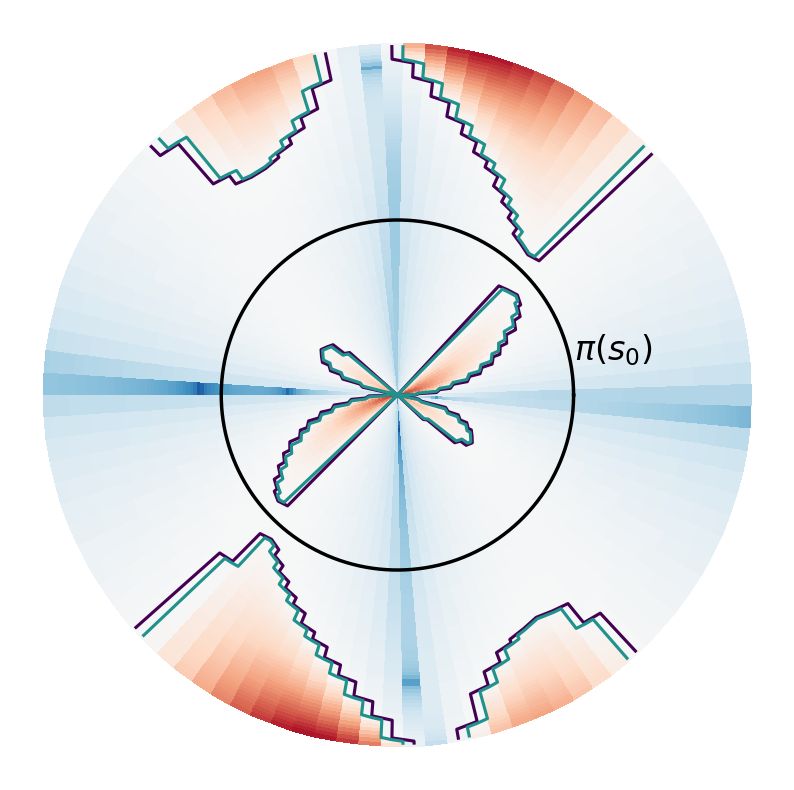

In [32]:
 # TN
plt.figure(figsize=(10,10))
plt.pcolormesh(grid_x, grid_y, np.power(rho_algos[:,:,1], 1/T),  norm=TwoSlopeNorm(1, vmin=valmin, vmax=valmax), cmap='RdBu_r')
plt.axis([grid_x.min()-0.1, grid_x.max()+0.1, grid_y.min()-0.1, grid_y.max()+0.1])
plt.plot(stat_pi[0]*np.cos(np.linspace(0, 2*np.pi, 500)), stat_pi[0]*np.sin(np.linspace(0, 2*np.pi, 500)), color='black', linewidth=2.5)
# plt.colorbar()
plt.contour(grid_x, grid_y, np.sign(rho_algos[:,:,1]-1), 1, style='--')
plt.text(0.50, 0.1, r'$\pi(s_0)$', fontsize=24)
plt.axis('off')

<ipython-input-33-3182e3d136d9>:3: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  plt.pcolormesh(grid_x, grid_y, np.power(rho_algos[:,:,4], 1/T),  norm=TwoSlopeNorm(1, vmin=valmin, vmax=valmax), cmap='RdBu_r')
<ipython-input-33-3182e3d136d9>:7: UserWarning: The following kwargs were not used by contour: 'style'
  plt.contour(grid_x, grid_y, np.sign(rho_algos[:,:,4]-1), 1, style='--')


(-1.099496542383185, 1.1, -1.099874127673875, 1.099874127673875)

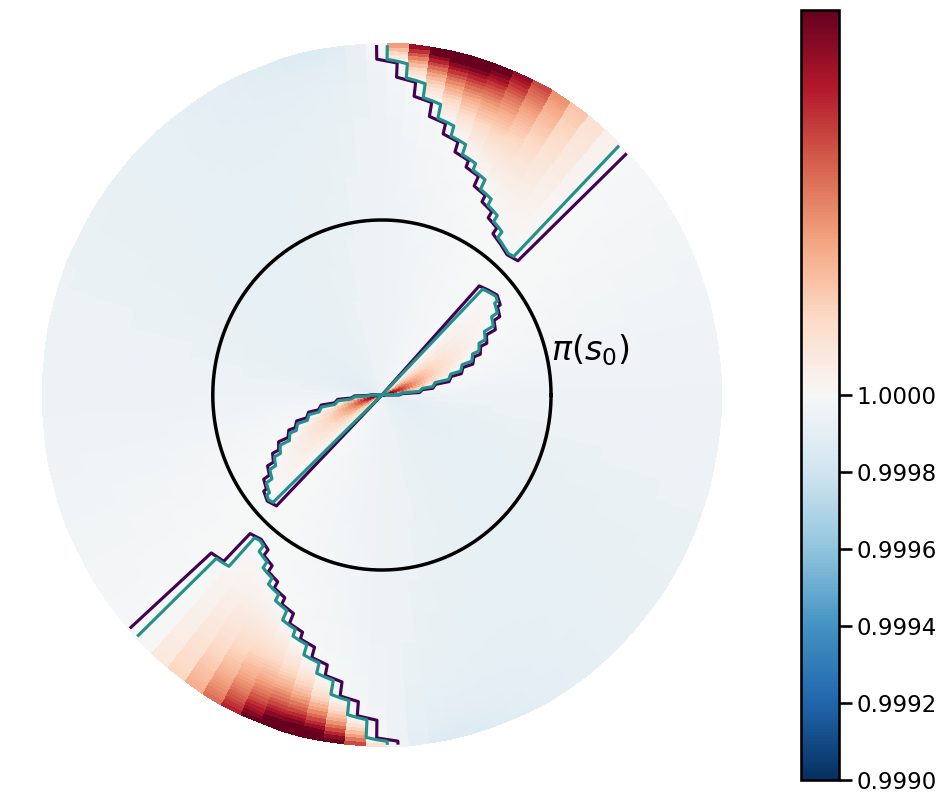

In [33]:
# FR
plt.figure(figsize=(12,10))
plt.pcolormesh(grid_x, grid_y, np.power(rho_algos[:,:,4], 1/T),  norm=TwoSlopeNorm(1, vmin=valmin, vmax=valmax), cmap='RdBu_r')
plt.axis([grid_x.min()-0.1, grid_x.max()+0.1, grid_y.min()-0.1, grid_y.max()+0.1])
plt.plot(stat_pi[0]*np.cos(np.linspace(0, 2*np.pi, 500)), stat_pi[0]*np.sin(np.linspace(0, 2*np.pi, 500)), color='black', linewidth=2.5)
plt.colorbar()
plt.contour(grid_x, grid_y, np.sign(rho_algos[:,:,4]-1), 1, style='--')
plt.text(0.50, 0.1, r'$\pi(s_0)$', fontsize=24)

plt.axis('off')